# Twitter data preparation

Data is from http://help.sentiment140.com/for-students/
This is a personal project to clean the data here and use it in the future.

In [1]:
import chardet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cols = ['sentiment','id','date','query_string','user','text']


In [ ]:
"""def find_encoding(fname):
    r_file = open(fname, 'rb').read()
    result = chardet.detect(r_file)
    charenc = result['encoding']
    return charenc
my_encoding = find_encoding('training.1600000.processed.noemoticon.csv')
my_encoding"""

Encoding for this file is 'Windows-1252' with a confidence 0.729385
Testing different encodings, as it is not sure what the encoding is.

In [3]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv', header=None, names=cols, engine='python',encoding='ISO-8859-1')
df.head()

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df.sentiment.value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

1.6 million entries, no null entries, and for the 'sentiment' column, even though the dataset description mentioned a neutral class with a value of '2', the training set has no neutral class.
Exactly 50% of the data is with negative label, and the other 50% with positive label.

For sentiment analysis, the only columns needed are the 'sentiment' column and the 'text' column.
The four columns listed below will not be used, and will be dropped.

“id” column is unique ID
“date” column is for date info
“query_string” column indicates whether the tweet has been collected with any particular query key word, but for this column, 100% of the entries are with value “NO_QUERY”
“user” column is the twitter user name

In [5]:
df.drop(['id','date','query_string','user'],axis=1,inplace=True)

In [6]:
df[df.sentiment == 0].head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [7]:
df[df.sentiment == 4].head()

,sentiment,text
800000,4,I LOVE @Health4UandPets u guys r the best!!
800001,4,im meeting up with one of my besties tonight! ...
800002,4,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,4,Being sick can be really cheap when it hurts t...
800004,4,@LovesBrooklyn2 he has that effect on everyone


# Data Preparation

In [8]:
#Tracking the length of the text before any cleaning is done.
df['pre_clean_len'] = [len(x) for x in df.text]

In [9]:
from pprint import pprint
data_dict = {
    'sentiment':{
        'type':df.sentiment.dtype,
        'description':'sentiment class - 0:negative, 1:positive'
    },
    'text':{
        'type':df.text.dtype,
        'description':'tweet text'
    },
    'pre_clean_len':{
        'type':df.pre_clean_len.dtype,
        'description':'Length of tweet pre-cleaning'
    },
    
    'dataset_shape':df.shape
}

pprint(data_dict)

{'dataset_shape': (1600000, 3),
 'pre_clean_len': {'description': 'Length of tweet pre-cleaning',
                   'type': dtype('int64')},
 'sentiment': {'description': 'sentiment class - 0:negative, 1:positive',
               'type': dtype('int64')},
 'text': {'description': 'tweet text', 'type': dtype('O')}}


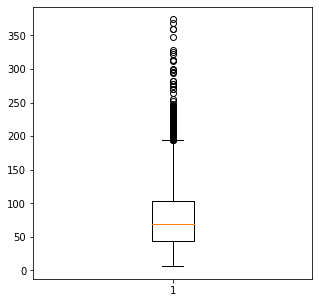

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.pre_clean_len)
plt.show()

Tweets have a character limit of 140. The graph shows a lot of tweets over this number.
Let's investigate

In [11]:
df[df.pre_clean_len > 140].head()

,sentiment,text,pre_clean_len
213,0,Awwh babs... you look so sad underneith that s...,142
226,0,Tuesdayï¿½ll start with reflection ï¿½n then a...,141
279,0,Whinging. My client&amp;boss don't understand ...,145
343,0,@TheLeagueSF Not Fun &amp; Furious? The new ma...,145
400,0,#3 woke up and was having an accident - &quot;...,144


Data Prep 1: Handling HTML Decoding

HTML encoding was not converted to text and instead shows up as ('&amp', '&quot', etc.).
Will use BeautifulSoup to decode the html to general text.

In [12]:
df.text[400]

"#3 woke up and was having an accident - &quot;It's pushing, it's pushing!&quot; he was crying because he couldn't stop from wetting his pants.  "

In [13]:
from bs4 import BeautifulSoup
example1 = BeautifulSoup(df.text[400], 'html.parser')
print(example1.prettify())

#3 woke up and was having an accident - "It's pushing, it's pushing!" he was crying because he couldn't stop from wetting his pants.



Data Prep 2: '@username'
'@username' mentions another twitter username, but will not be used for the sentiment analysis model.
Next step is to remove these mentions.

In [14]:
df.text[343]

'@TheLeagueSF Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down '

In [15]:
import re
re.sub(r'@[A-Za-z0-9]+','',df.text[343])

' Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down '

Data Prep 3: URL links.
Similar to the '@username', the links do not contribute to sentiment analysis
Next step is to remove the links.

In [16]:
df.text[0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [17]:
re.sub('https?://[A-Za-z0-9./]+','',df.text[0])

"@switchfoot  - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

Data Prep 4: hashtag/numbers
Just removing the hashtag, the word may still provide useful

In [18]:
df.text[175]

"@machineplay I'm so sorry you're having to go through this. Again.  #therapyfail"

In [19]:
re.sub('[^a-zA-Z]', ' ',df.text[175])

' machineplay I m so sorry you re having to go through this  Again    therapyfail'

In [20]:

from nltk.tokenize import WordPunctTokenizer
token = WordPunctTokenizer()
pattern1 = r'@[A-Za-z0-9]+'
pattern2 = r'https?://[A-Za-z0-9./]+'
combined_pattern = r'|'.join((pattern1,pattern2))

In [21]:
def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'html.parser')
    souped = soup.prettify()
    stripped = re.sub(combined_pattern, '', souped)
    letters_only = re.sub('[^a-zA-Z]', ' ', stripped)
    lower_case = letters_only.lower()
    
    words = token.tokenize(lower_case)
    return (' '.join(words)).strip()

In [22]:
temp = df.text[225:227]

In [23]:
result = []
for t in temp:
    result.append(tweet_cleaner(t))

In [24]:
result

['shooting outside my house o not kidding so scared',
 'tuesday ll start with reflection n then a lecture in stress reducing techniques that sure might become very useful for us accompaniers']

In [25]:
#Running the entire set of 1.6 million tweets through the previously defined tweet_cleaner.
final = []
for text in df.text:
    final.append(tweet_cleaner(text))

C:\Users\SonOfFiery\Anaconda3\lib\site-packages\bs4\__init__.py:314: UserWarning: "b' i just received my G8 viola exam.. and its... well... .. disappointing.. :\\..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\SonOfFiery\Anaconda3\lib\site-packages\bs4\__init__.py:314: UserWarning: "b'E3 ON PLAYSTATION HOME IN ABOUT AN HOUR!!!!!!!!!! \\../  \\../'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [26]:
#Placing cleaned data back into a dataframe, with the target(sentiment) pulled from the original df
clean_df = pd.DataFrame(final, columns=['text'])
clean_df['target'] = df.sentiment

In [27]:
clean_df.head()

,text,target
0,awww that s a bummer you shoulda got david car...,0
1,is upset that he can t update his facebook by ...,0
2,i dived many times for the ball managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,no it s not behaving at all i m mad why am i h...,0


In [28]:
#saving to a csv
clean_df.to_csv('cleaned_tweets.csv',encoding='utf-8')